# Выпускной проект металлургическая промышленность

### Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать.

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-success" style="border-color: green; border-radius: 5px">
<b> КОММЕНТАРИЙ МЕНТОРА 2</b><br>👍

In [ ]:
!pip install -Uq scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install lightgbm -q
!pip install catboost -q
!pip install xgboost -q
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from phik import phik_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   PolynomialFeatures,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error ,mean_absolute_error, r2_score, make_scorer, root_mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor, VotingClassifier

from warnings import simplefilter

import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

from phik.report import plot_correlation_matrix
from phik import report

import re
import shap

In [ ]:
def researchvis_num_features(df, df_features, color):

    for feat in df_features:

        fig, ax = plt.subplots(2, 1, figsize=(10, 7))
        plt.subplots_adjust(hspace=0.5)
        sns.histplot(ax=ax[0], data=df, x=df[feat], kde=True, bins=100, color=color)

        ax[0].set_ylabel('Частота')
        ax[0].set_title(f'Распределение показателей {df[feat].name}', fontsize=12)

        sns.boxplot(ax=ax[1], data=df, x=df[feat], color=color, medianprops={'color': "darkred", "linewidth": 2})
        ax[1].set_title(f'Диаграмма размаха {df[feat].name}', fontsize = 12)


In [ ]:
def correlation_plot(df, df_features, target):

    for feat in df_features:

        fig, ax = plt.subplots(figsize=(10, 7))
        sns.scatterplot(data=df, y=df[target], x=df[feat], alpha=.7, color='darkgreen')

        ax.set_ylabel('Кол-во')
        ax.set_title(f'Корреляция показателей {df[feat].name} с {df[target].name}', fontsize=12)


In [ ]:
def drop_keys(data, missing_keys):

  data_cleaned = data[~data['key'].isin(missing_keys)]
  return data_cleaned

In [ ]:
def phik_features_matrix(df, interval_cols):
    phik_overview = phik_matrix(df, interval_cols=interval_cols)

    plot_correlation_matrix(
           phik_overview.values,
           x_labels=phik_overview.columns,
           y_labels=phik_overview.index,
          title=r"Матрица корреляций $\phi_K$",
          fontsize_factor=1.5,
          figsize=(12, 9)
)

# Загрузка данных

In [ ]:
data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_arc_new.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


In [ ]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_new.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [ ]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [ ]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_temp_new.tail()

,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


In [ ]:
data_temp_new['key'].nunique()

3216

Проблема с кол-вом ключей, в идеале должно быть 3241. Значит Во всех датасетах участвующих в исследовании есть такая проблема. Количество ключей в них стоит привести к состветствию.

In [ ]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Явные дубликаты в столбце key

In [ ]:
data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_new.tail()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Выводы после первичного знакомства с данными:

  - Данные о подаче электродов и изменению температуры разбиты по ключам с уникальными ковшами, т.е отображается сам процесс во времени по каждому ковшу, который состоит обычно из 4-5 итераций судя по уникальному числу ковшей.

  - Данные о подаче инертного газа, сыпучих и проволочных материалов соответсвуют уникакальным ключам, каждый своему, т.к каждая из операций проводилась над сплавом всего один раз.

  - В датасетах с сыпучими и проволочными материалами у множества признаков критичиское кол-во пропусков, что делает их неиформаативными.

  - Во всех датасетах кол-во ключей разное и в каждом оно меньше чем максимальное значение ключа в 3241.

Вроде расхождений больше нет, можно двигаться дальше. Получилось длинно и не очень красиво, зато мы удостоверились, что все совпадает. После ревью оформлю в более адекватную функцию. Решить проблему с расхождением в размерности датасетов с электродами и температурой. Судя по всему в датасете с подачей электродов немного больше значений итераций, чем изменения температуры после их проведения.

# Исследовательский анализ данных

### Исследовательский анализ данных о электродах(data_arc_new)

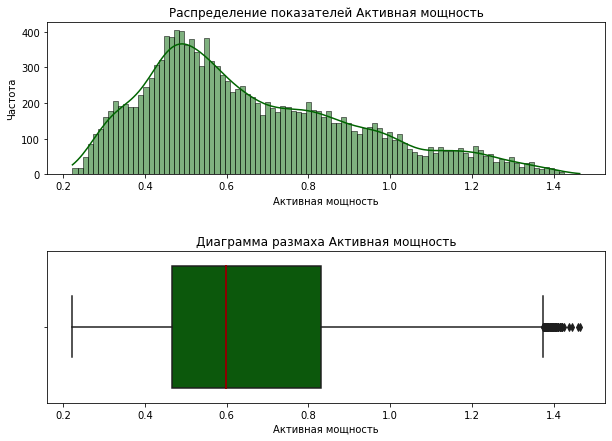

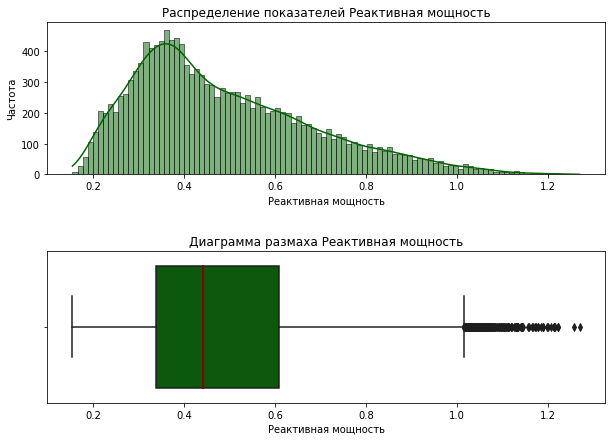

In [ ]:
data_arc_new = data_arc_new[data_arc_new['Реактивная мощность'] > -1]
dan = ['Активная мощность', 'Реактивная мощность']
researchvis_num_features(data_arc_new, dan, 'darkgreen')

In [ ]:
data_arc_new.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14875.0,1615.186756,934.593897,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14875.0,0.662749,0.258894,0.223120,0.467115,0.599578,0.830135,1.463773
Реактивная мощность,14875.0,0.487115,0.197612,0.153777,0.337190,0.441665,0.608223,1.270284


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


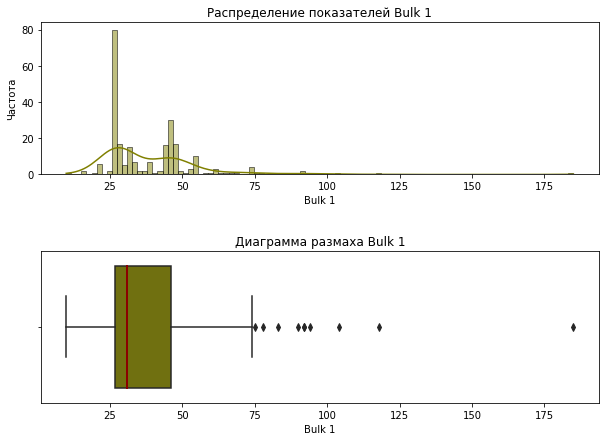

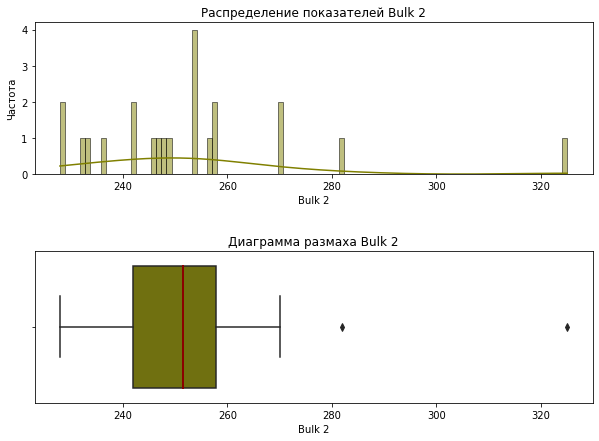

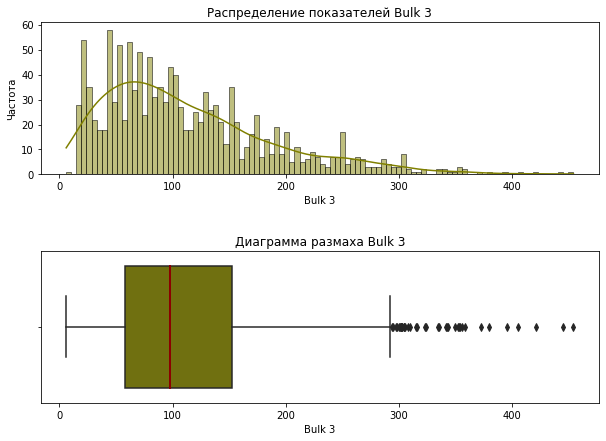

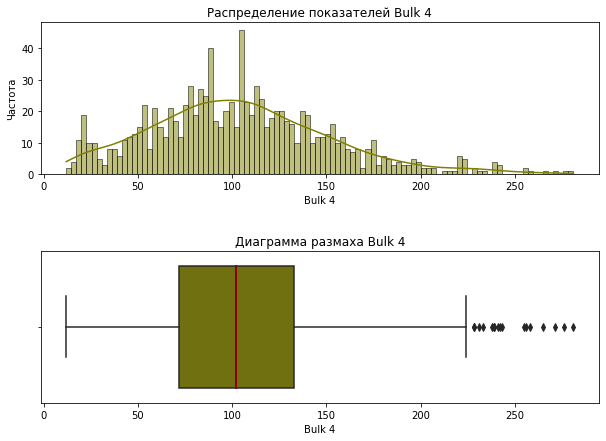

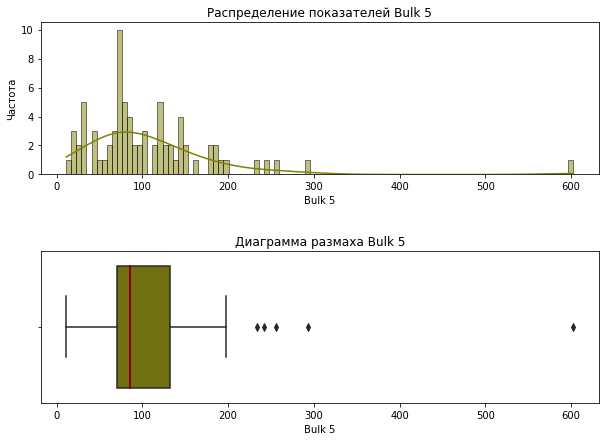

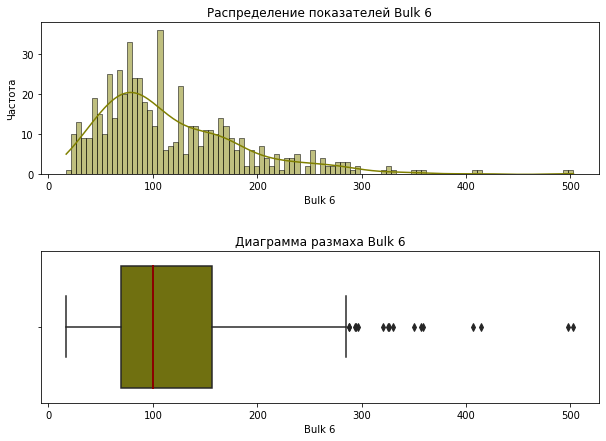

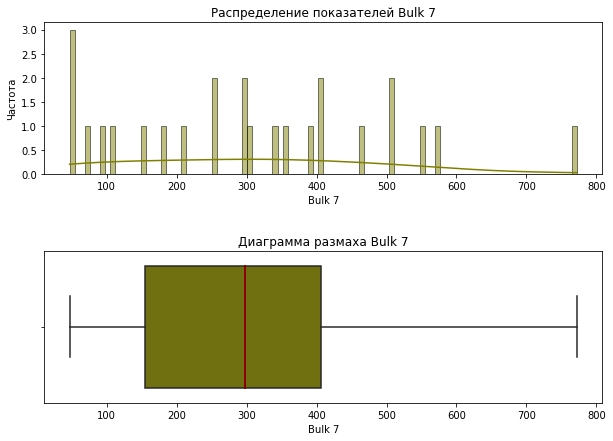

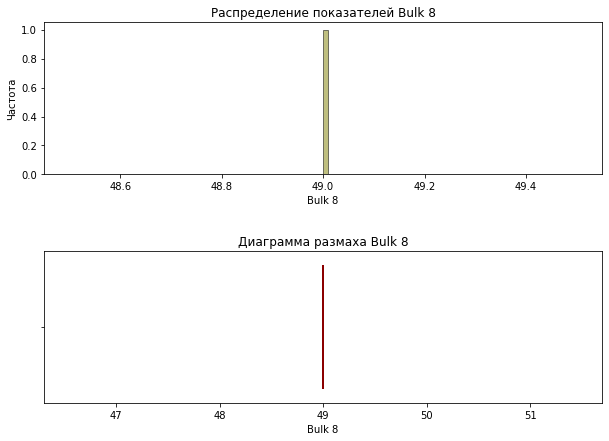

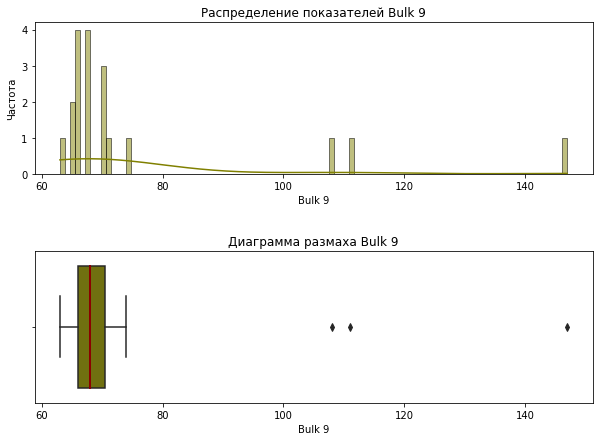

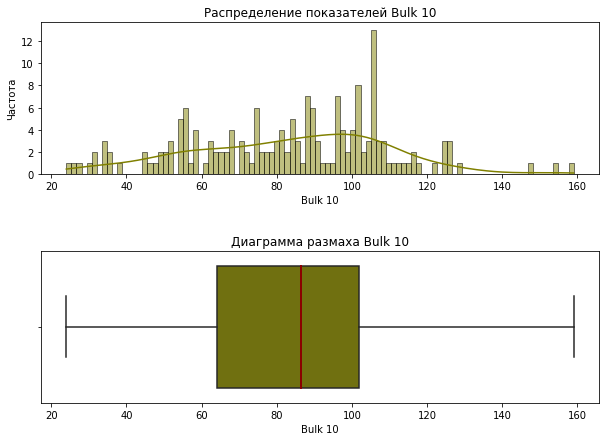

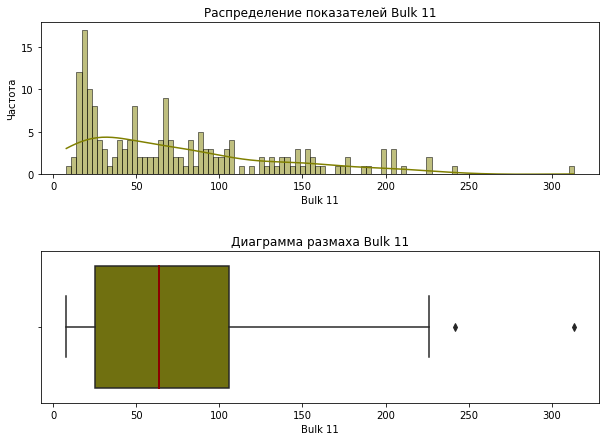

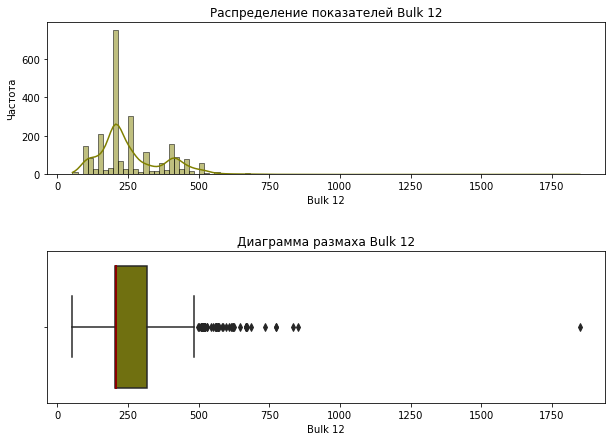

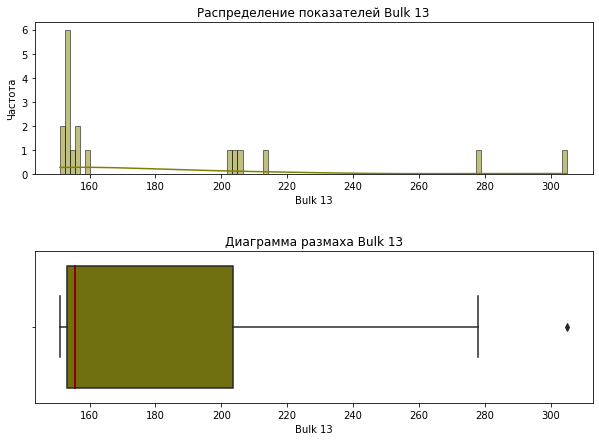

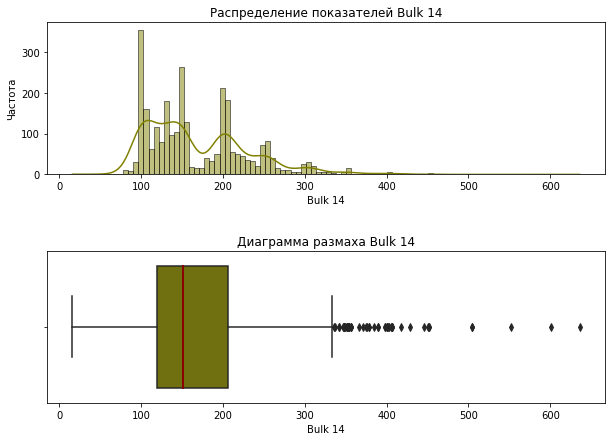

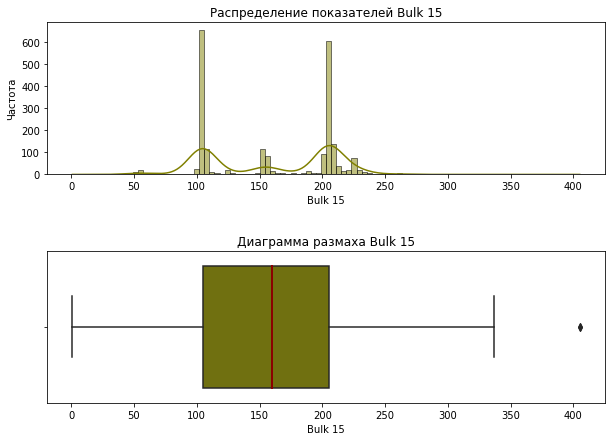

In [ ]:
dbn = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15']

researchvis_num_features(data_bulk_new, dbn, 'olive')

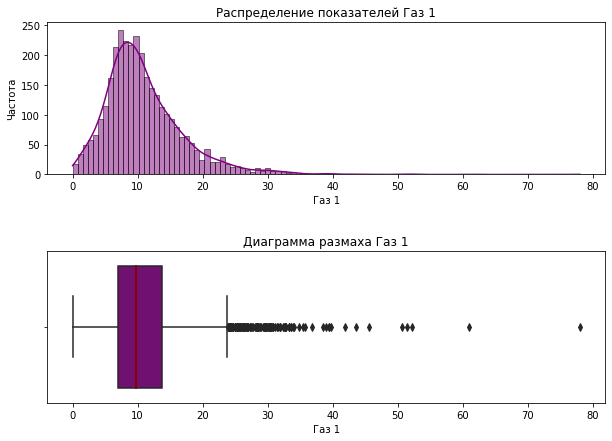

In [ ]:
researchvis_num_features(data_gas_new, ['Газ 1'], 'purple')

In [ ]:
data_gas_new.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [ ]:
data_temp_new = data_temp_new[data_temp_new['Температура'] > 1400]

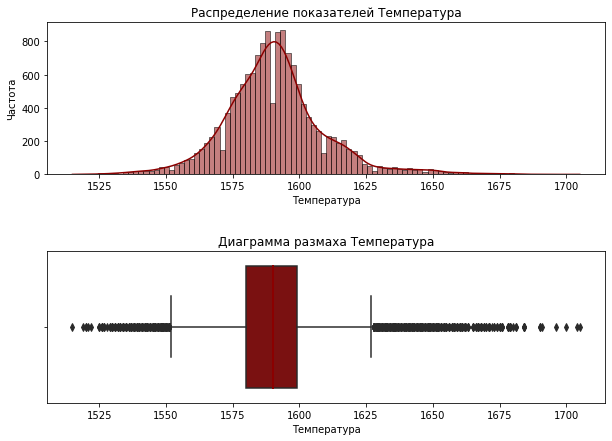

In [ ]:
researchvis_num_features(data_temp_new, ['Температура'], 'darkred')

In [ ]:
data_temp_new.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14660.0,1325.369236,787.407873,1.0,654.0,1314.0,1962.25,3241.0
Температура,14660.0,1590.852729,19.143141,1515.0,1580.0,1590.0,1599.00,1705.0


In [ ]:
data_temp_new[data_temp_new['Температура'] < 1400]

,key,Время замера,Температура


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


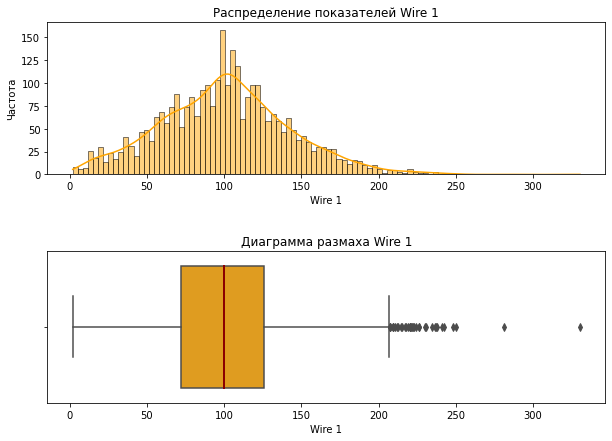

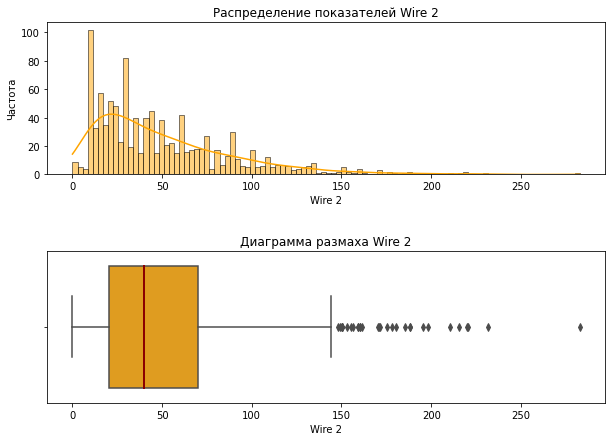

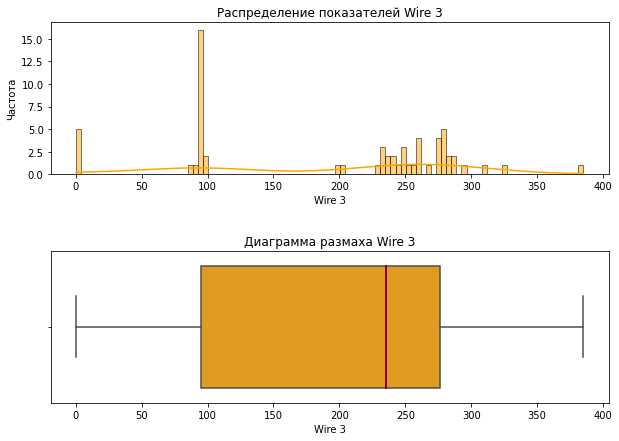

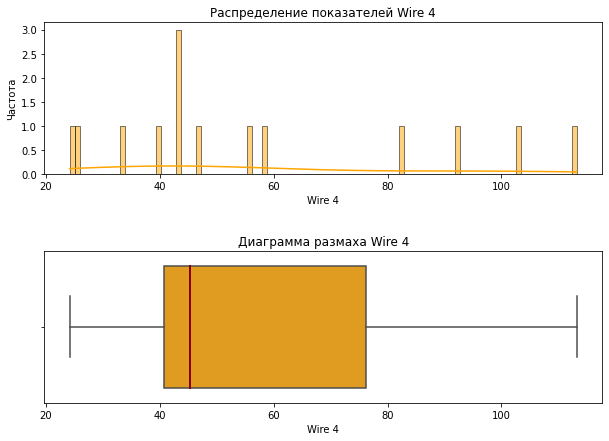

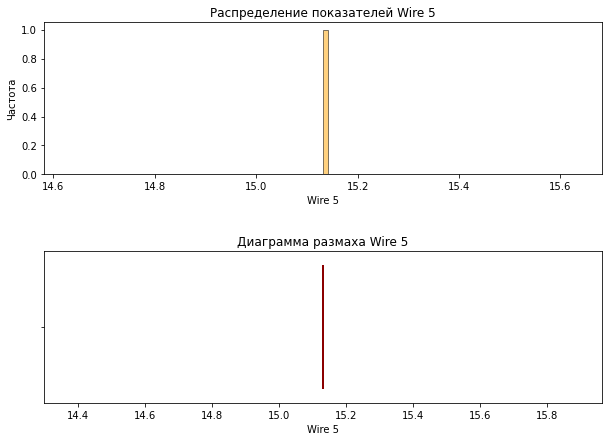

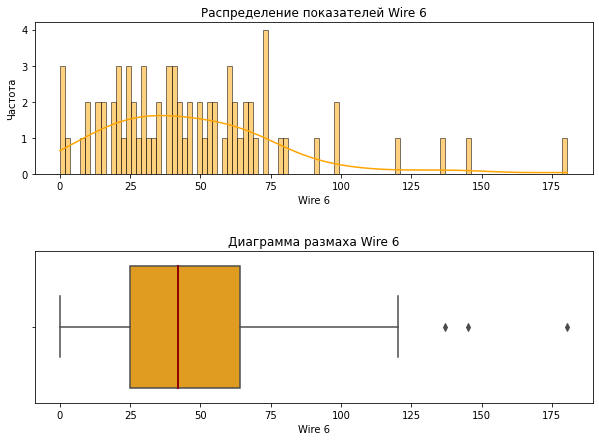

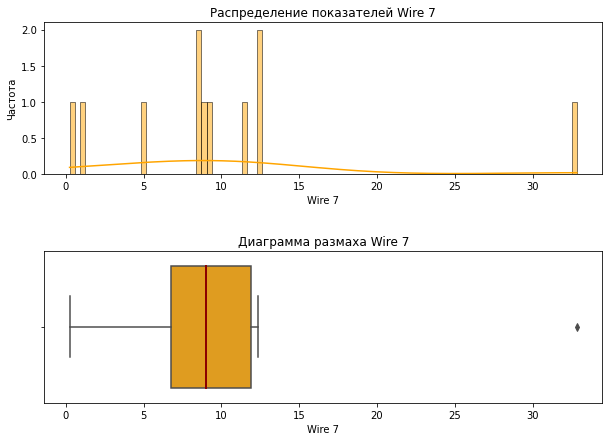

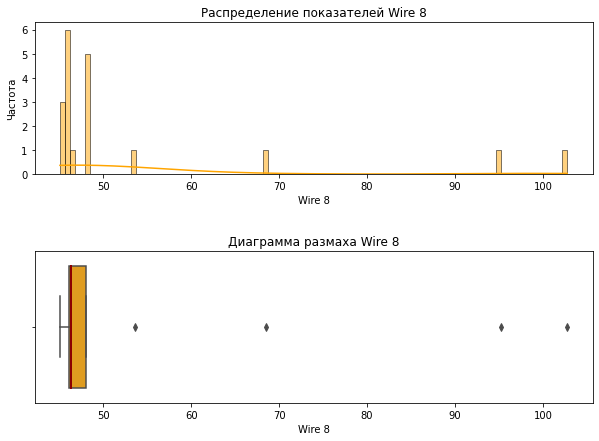

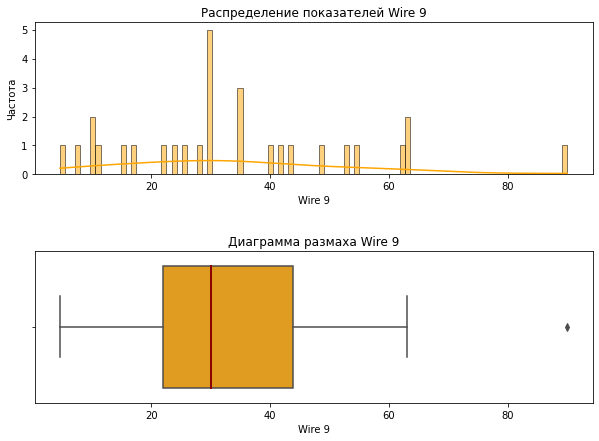

In [ ]:
dwn = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9']
researchvis_num_features(data_wire_new, dwn, 'orange')

## Вывод по итогу иследовательского анализа

По итогу проведения исследовательского анализа данных о метталлобработке было выяснено:


1) Данные о нагреве спомощью эелектродов(датасет data_arc_new):

  - Активная мощность распределена нормально, среднее 0.66, область нормальных значений от 0.4 до 0.8.

  - Реактиваня мощность распредлена нормально, среднее 0.48, область нормальных значений 0.4 до 0.6.

  - Структура данных такая: каждая отдельная процедура переплавки сопровождается множеством подач электродов к ковшу, в процессе подачи температура металла меняется.

2) Данные о сыпучих материалах(data_bulk_new):

  - В датасете присутвует 15 различных признаков, характеризующих обьем подачи сыпучих материалов.

  - Большинство признаков не информативны, там попросту не хватает данных, многие заполнены менее чем на 10%, скорее всего такие признаки лучше не брать во внимании при дальнейшем обучении модели, стоит оставить только те признаки, в которых достаточно данных. Мы не знаем насколько были спецефичны те или иные сыпучие матриалы, поскольку качество у поступающей на предприятие руды разное и везут ее из разных регионов.

3) Данные о подаче инертных газов(азот)(data_gas_new):

  - Данные распределены нормально, среднее 11, область нормальных значений от 0 до 25, область между первым и третьим квартилем от 7, до 13.7.

  - Максимальное значение 80, что в 8 раз выше нормы и одноится к райнему выбросу, однако это не аномалия и пока не вижу смысла предпринимать меры по предобработке данных в этом датасете.

4) Данные об изменении температуры(data_temp_new):

  - Распределние температуры норамльное, среднее 1590, большинство значений находятся в диапазоне от 1560 и до 1630.

  - Максимальный показатель равен 1711, минимальный 1191. Минимум значительно отличается от средних показателей, в районе 1200 находится целая группа таких значений, трудно предсказать природу их появления, к тому же такие занчения наблюдаются на разных партиях металла, значит это значение было начальным для этих партий, после чего пришло в норму.

5) Данные о проволочных материалах(data_wire_new):

  - В датасете пристутсвует 9 различных признаков, каждый из которых связан с конкретным металлом, из которого и изготовлене проволока.

  - Пристутствуют аналогичные проблемы, что и в датасете с сыпучими материалами, слишком низкая информативность данных, поэтому часть признаков не будет передана модели.

6) Датасеты и столбцы с датой и временем:

  - Эти данные не несут полезной нагрузки для обучения модели и учавствовать в обучении не будут.


# Объединение данных

In [ ]:
agg_data_arc_new = data_arc_new.groupby('key').agg({
    'Активная мощность': 'sum',
    'Реактивная мощность': 'sum'
}).reset_index()
agg_data_arc_new.head()

,key,Активная мощность,Реактивная мощность
0,1,3.036730,2.142821
1,2,2.139408,1.453357
2,3,4.063641,2.937457
3,4,2.706489,2.056992
4,5,2.252950,1.687991


In [ ]:
agg_data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3214 non-null   int64  
 1   Активная мощность    3214 non-null   float64
 2   Реактивная мощность  3214 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.5 KB


Добавим два новых признака и агрегируем данные по по последнему и первому значению в ключе.

In [ ]:
agg_data_temp_new = data_temp_new.groupby('key').agg(
    первая_температура=('Температура', 'first'),
    последняя_температура=('Температура', 'last')
).reset_index()

agg_data_temp_new = agg_data_temp_new.dropna(subset=['последняя_температура'])

In [ ]:
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])

data_arc_new['Длительность нагревания'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.total_seconds()

duration_heating = data_arc_new.groupby('key')['Длительность нагревания'].sum().reset_index()

In [ ]:
duration_heating.head()

,key,Длительность нагревания
0,1,1098.0
1,2,811.0
2,3,655.0
3,4,741.0
4,5,869.0


In [ ]:
agg_data_temp_new.head()

,key,первая_температура,последняя_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [ ]:
agg_data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 0 to 3214
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    3215 non-null   int64  
 1   первая_температура     3215 non-null   float64
 2   последняя_температура  3215 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 100.5 KB


In [ ]:
data_temp_new['Время изменения температуры'] = data_temp_new.groupby('key')['Время замера'].transform(lambda x: (pd.to_datetime(x) - pd.to_datetime(x.min())).dt.total_seconds())

duration_increase_temperature = data_temp_new.groupby('key')['Время изменения температуры'].sum().reset_index()

In [ ]:
duration_increase_temperature.head()

,key,Время изменения температуры
0,1,4993.0
1,2,3200.0
2,3,5482.0
3,4,2862.0
4,5,3994.0


In [ ]:
dbn = ['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']
dwn = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']

data_bulk_new = data_bulk_new.drop(dbn, axis=1)
data_wire_new = data_wire_new.drop(dwn, axis=1)

In [ ]:
data_wire_new[data_wire_new.drop('key', axis=1).columns] = data_wire_new[data_wire_new.drop('key', axis=1).columns].fillna(0)
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


In [ ]:
data_bulk_new[data_bulk_new.drop('key', axis=1).columns] = data_bulk_new[data_bulk_new.drop('key', axis=1).columns].fillna(0)
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 3   3129 non-null   float64
 3   Bulk 4   3129 non-null   float64
 4   Bulk 6   3129 non-null   float64
 5   Bulk 12  3129 non-null   float64
 6   Bulk 14  3129 non-null   float64
 7   Bulk 15  3129 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 195.7 KB


In [ ]:
data_final = data_wire_new.merge(data_bulk_new, how='inner', on='key')
data_final = data_final.merge(agg_data_arc_new, how='inner', on='key')
data_final = data_final.merge(data_gas_new, how='inner', on='key')
data_final = data_final.merge(duration_heating, how='inner', on='key')
data_final = data_final.merge(duration_increase_temperature, how='inner', on='key')
data_final = data_final.merge(agg_data_temp_new, how='inner', on='key')
data_final = data_final.drop_duplicates()

In [ ]:
data_final.head()

,key,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Активная мощность,Реактивная мощность,Газ 1,Длительность нагревания,Время изменения температуры,первая_температура,последняя_температура
0,1,60.059998,0.00000,0.0,0.0,43.0,0.0,206.0,150.0,154.0,3.036730,2.142821,29.749986,1098.0,4993.0,1571.0,1613.0
1,2,96.052315,0.00000,0.0,0.0,73.0,0.0,206.0,149.0,154.0,2.139408,1.453357,12.555561,811.0,3200.0,1581.0,1602.0
2,3,91.160157,0.00000,0.0,0.0,34.0,0.0,205.0,152.0,153.0,4.063641,2.937457,28.554793,655.0,5482.0,1596.0,1599.0
3,4,89.063515,0.00000,0.0,0.0,81.0,0.0,207.0,153.0,154.0,2.706489,2.056992,18.841219,741.0,2862.0,1601.0,1625.0
4,5,89.238236,9.11456,0.0,0.0,78.0,0.0,203.0,151.0,152.0,2.252950,1.687991,5.413692,869.0,3994.0,1576.0,1602.0


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021 entries, 0 to 3020
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          3021 non-null   int64  
 1   Wire 1                       3021 non-null   float64
 2   Wire 2                       3021 non-null   float64
 3   Bulk 1                       3021 non-null   float64
 4   Bulk 3                       3021 non-null   float64
 5   Bulk 4                       3021 non-null   float64
 6   Bulk 6                       3021 non-null   float64
 7   Bulk 12                      3021 non-null   float64
 8   Bulk 14                      3021 non-null   float64
 9   Bulk 15                      3021 non-null   float64
 10  Активная мощность            3021 non-null   float64
 11  Реактивная мощность          3021 non-null   float64
 12  Газ 1                        3021 non-null   float64
 13  Длительность нагре

In [ ]:
data_final.tail()

,key,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Активная мощность,Реактивная мощность,Газ 1,Длительность нагревания,Время изменения температуры,первая_температура,последняя_температура
3016,3237,38.088959,0.0,0.0,170.0,0.0,0.0,252.0,130.0,206.0,2.541872,2.025417,5.543905,909.0,0.0,1569.0,1569.0
3017,3238,56.128799,0.0,0.0,126.0,0.0,0.0,254.0,108.0,106.0,1.374821,1.038103,6.745669,546.0,0.0,1584.0,1584.0
3018,3239,143.357761,0.0,0.0,0.0,0.0,114.0,158.0,270.0,88.0,4.848005,3.541541,16.023518,1216.0,0.0,1598.0,1598.0
3019,3240,34.070400,0.0,0.0,0.0,0.0,26.0,0.0,192.0,54.0,3.317679,2.373552,11.863103,839.0,0.0,1617.0,1617.0
3020,3241,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,3.045283,2.140011,12.680959,659.0,0.0,1586.0,1586.0


Как мы видим у многих ковшей значения первой и последней температуры совпадают, что недопустимо для модели, эти ковши следует убрать

In [ ]:
data_final = data_final[data_final['первая_температура'] != data_final['последняя_температура']]

In [ ]:
data_final.tail()

,key,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Активная мощность,Реактивная мощность,Газ 1,Длительность нагревания,Время изменения температуры,первая_температура,последняя_температура
2324,2495,89.150879,0.00000,0.0,21.0,0.0,0.0,256.0,129.0,223.0,3.168133,2.210936,7.125735,723.0,3463.0,1570.0,1591.0
2325,2496,114.179527,0.00000,0.0,0.0,63.0,0.0,256.0,129.0,226.0,4.174918,2.872031,9.412616,940.0,5702.0,1554.0,1591.0
2326,2497,94.086723,9.04800,0.0,0.0,85.0,0.0,230.0,124.0,226.0,3.605239,2.452092,6.271699,569.0,1876.0,1571.0,1589.0
2327,2498,118.110717,0.00000,0.0,90.0,0.0,0.0,206.0,129.0,207.0,3.202310,2.239820,14.953657,750.0,4739.0,1591.0,1594.0
2328,2499,110.160958,50.00528,0.0,47.0,0.0,0.0,233.0,126.0,227.0,1.737084,1.296836,11.336151,883.0,4112.0,1569.0,1603.0


In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2328
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2292 non-null   int64  
 1   Wire 1                       2292 non-null   float64
 2   Wire 2                       2292 non-null   float64
 3   Bulk 1                       2292 non-null   float64
 4   Bulk 3                       2292 non-null   float64
 5   Bulk 4                       2292 non-null   float64
 6   Bulk 6                       2292 non-null   float64
 7   Bulk 12                      2292 non-null   float64
 8   Bulk 14                      2292 non-null   float64
 9   Bulk 15                      2292 non-null   float64
 10  Активная мощность            2292 non-null   float64
 11  Реактивная мощность          2292 non-null   float64
 12  Газ 1                        2292 non-null   float64
 13  Длительность нагре

# Исследовательский и корреляционный анализ объединенного датасета

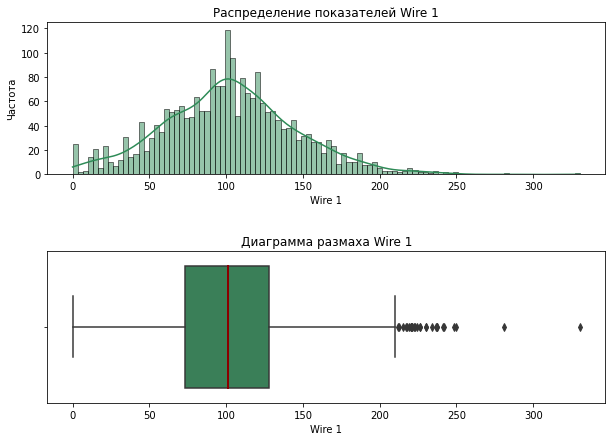

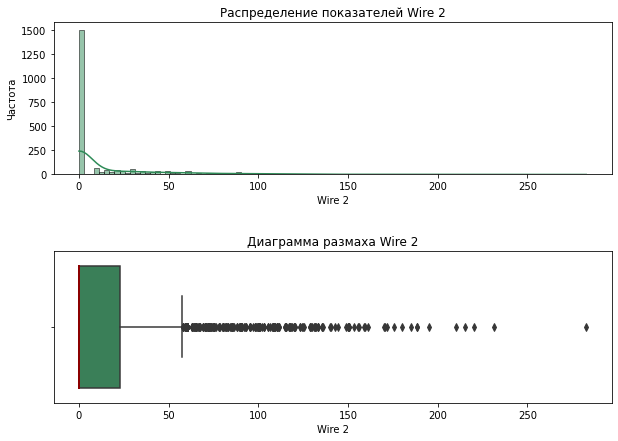

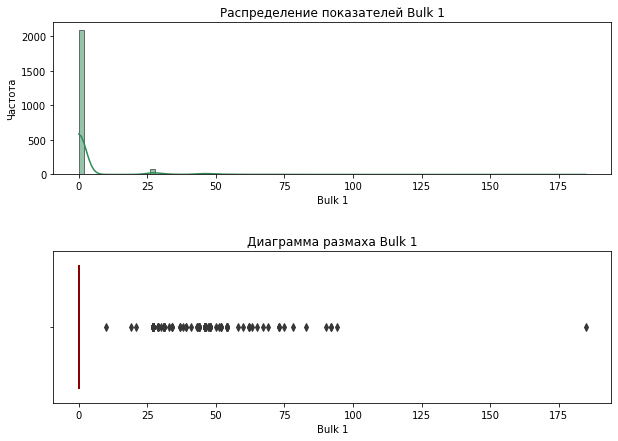

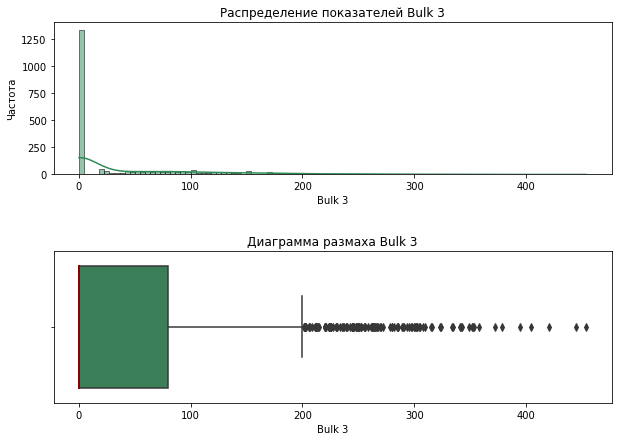

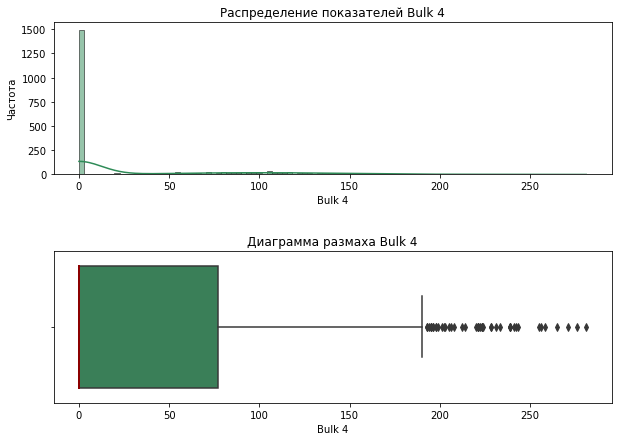

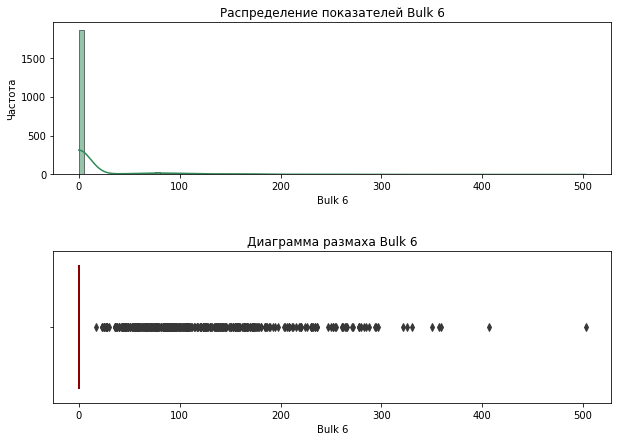

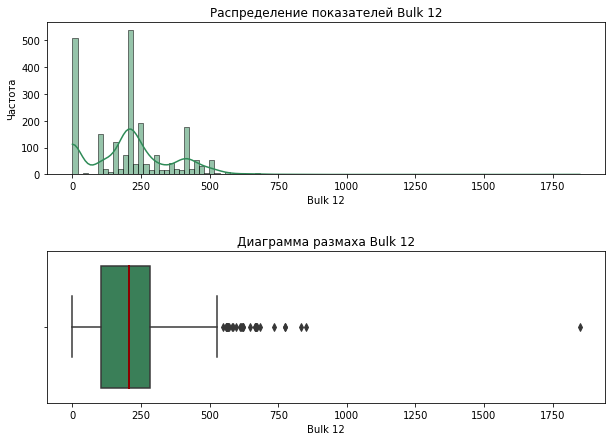

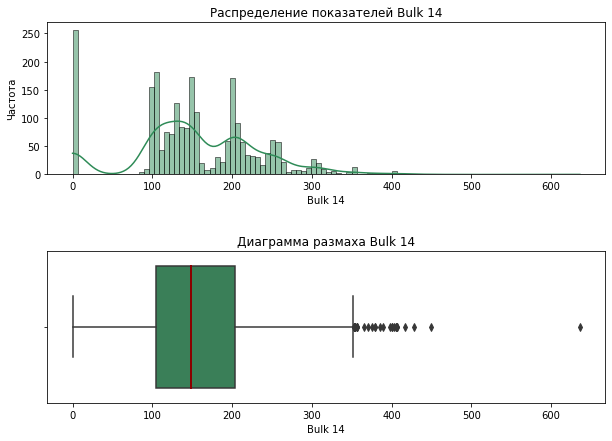

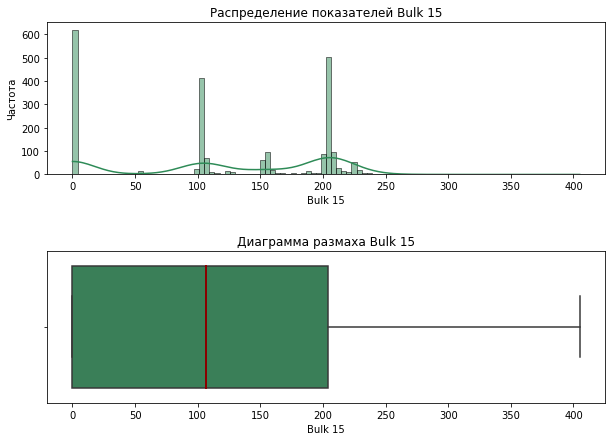

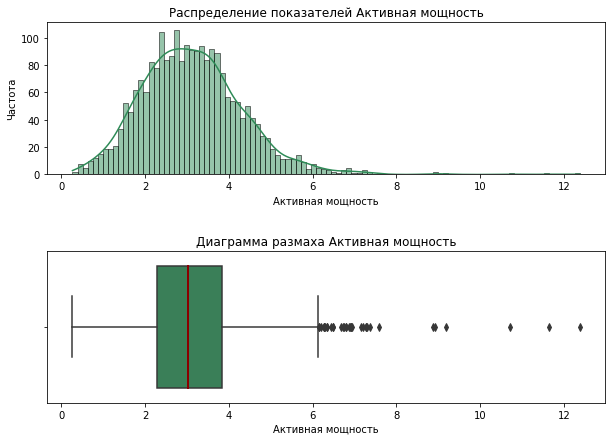

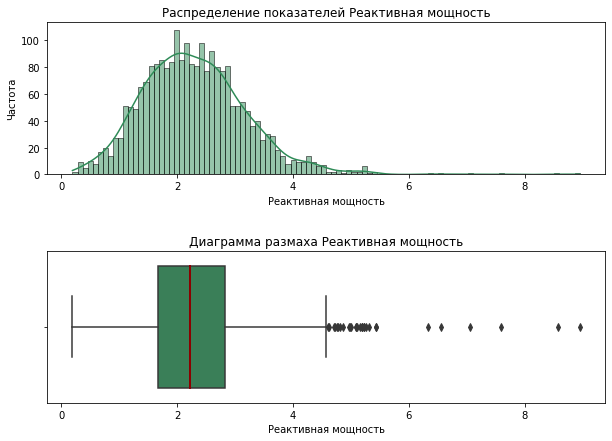

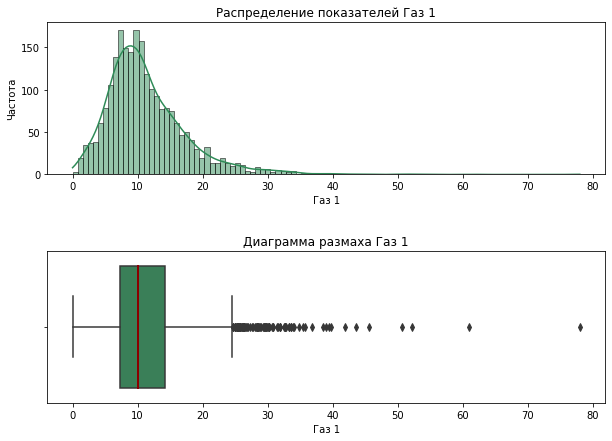

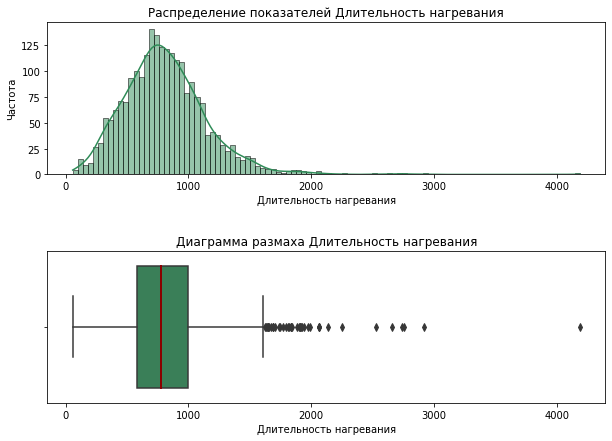

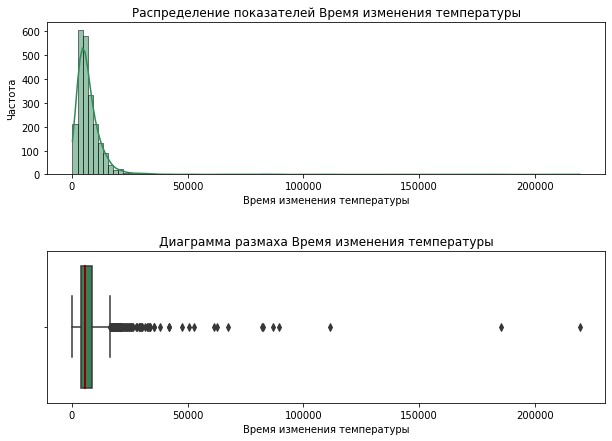

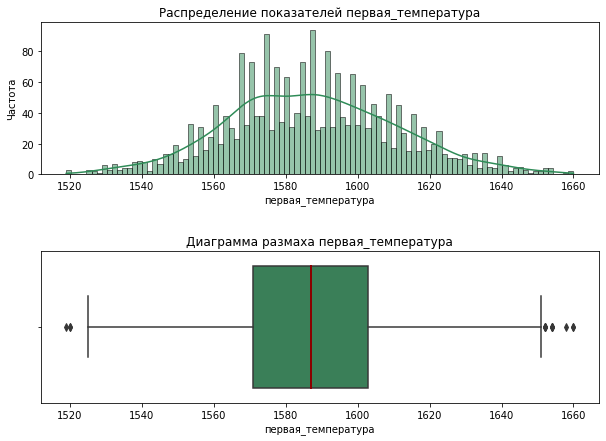

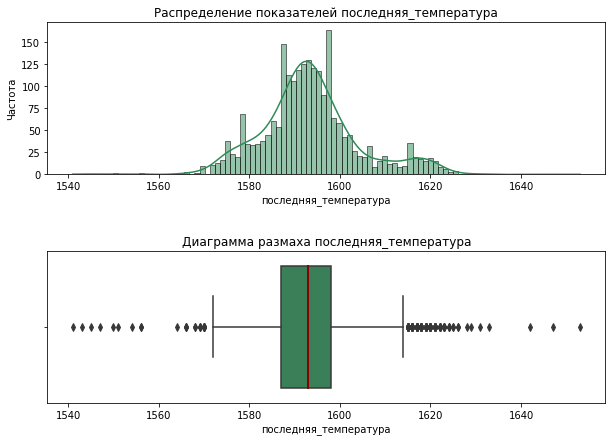

In [ ]:
num_cols = data_final.drop(['key'], axis=1).columns
researchvis_num_features(data_final, num_cols, 'seagreen')

In [ ]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
key,2292.0,1249.033595,715.245546,1.000000,626.750000,1250.500000,1864.250000,2499.000000
Wire 1,2292.0,102.430779,43.650477,0.000000,73.204559,101.058359,128.075222,330.314424
Wire 2,2292.0,17.718618,33.803546,0.000000,0.000000,0.000000,23.137141,282.780152
Bulk 1,2292.0,3.439354,12.428276,0.000000,0.000000,0.000000,0.000000,185.000000
Bulk 3,2292.0,47.667103,75.554794,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2292.0,37.143543,58.653842,0.000000,0.000000,0.000000,77.000000,281.000000
Bulk 6,2292.0,22.585515,56.086406,0.000000,0.000000,0.000000,0.000000,503.000000
Bulk 12,2292.0,208.696771,157.281272,0.000000,105.000000,206.000000,281.250000,1849.000000
Bulk 14,2292.0,154.105585,81.581301,0.000000,105.000000,149.000000,204.000000,636.000000
Bulk 15,2292.0,120.142234,84.744646,0.000000,0.000000,107.000000,204.000000,405.000000


В целом всё выглядит штатно, лучше обратить внимение на анализ сформированных признаков свзянных со временем.

1) Длительность нагревания выглядит стандартно, распредление можно считать нормальным, есть и выбросы, но их трудно отнести к экстримальным значениям. Среднее время нагревания составило 809 сек или 13.5 мин.

2) Время изменения температуры радует меньше, присутствуют выбивающиеся из общей картины выбросы, так в одном случае общее время за которе менялась температура ковша превышает 200 000 сек, это более двух суток, при среднем значении по признаку в 7526 сек, что примерно соответсвует 2 часам.

In [ ]:
data_final[data_final['Время изменения температуры'] > 100000]

,key,Wire 1,Wire 2,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Активная мощность,Реактивная мощность,Газ 1,Длительность нагревания,Время изменения температуры,первая_температура,последняя_температура
1578,1689,187.153206,0.000000,0.0,0.0,0.0,247.0,733.0,248.0,224.0,12.375636,8.949049,33.597044,4189.0,219309.0,1583.0,1606.0
1834,1958,123.308644,150.106322,0.0,31.0,0.0,175.0,310.0,180.0,202.0,6.915481,5.440920,32.449632,1834.0,111630.0,1579.0,1570.0
1973,2108,11.051040,0.000000,63.0,0.0,98.0,0.0,0.0,0.0,0.0,10.706804,7.589489,45.638999,2739.0,185454.0,1639.0,1541.0


В ковшах время изменения температуры, которых превышает 100 000 сек показатели активной и реактивной мощности, объемов подачи газа, длительность нагревания многократно превышают средние по датасету. Возможно, это просто очень длинные партии со специфичной характеристикой руды. Однако затраченные ресурсы на эту партию высоки, а времени потрачено чрезмерно много. Простой на предприятии и высокие затраты на электроенергию существенно снижают чистую прибыль с партии металла, таких происшествий лучше избегать.

# Корреляционный анализ

In [ ]:
num_cols = data_final.drop(['key', 'последняя_температура'], axis=1).columns

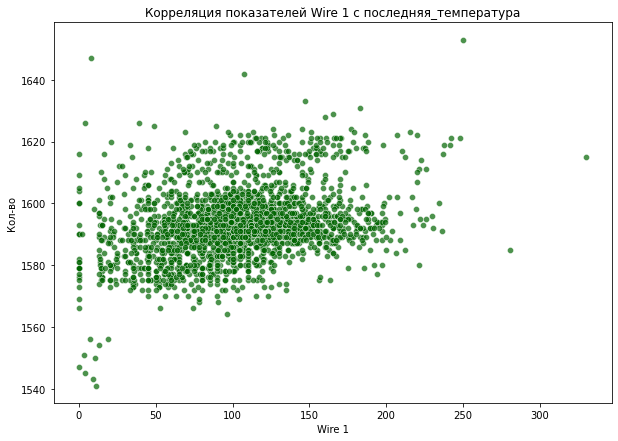

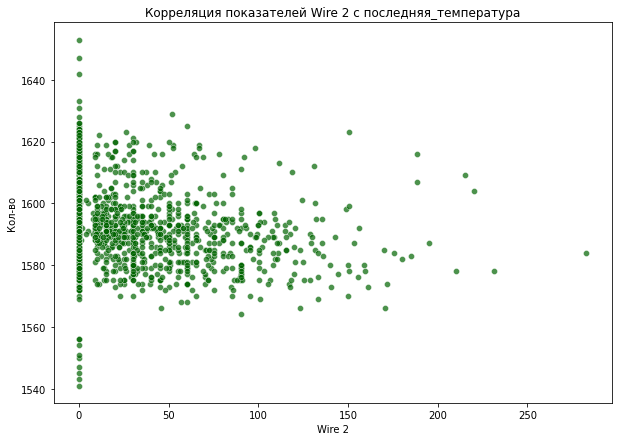

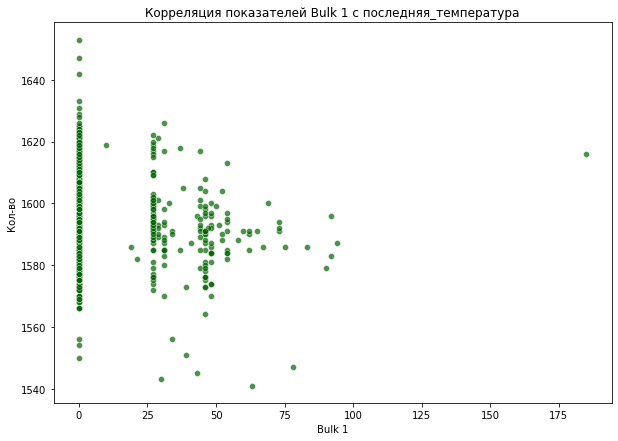

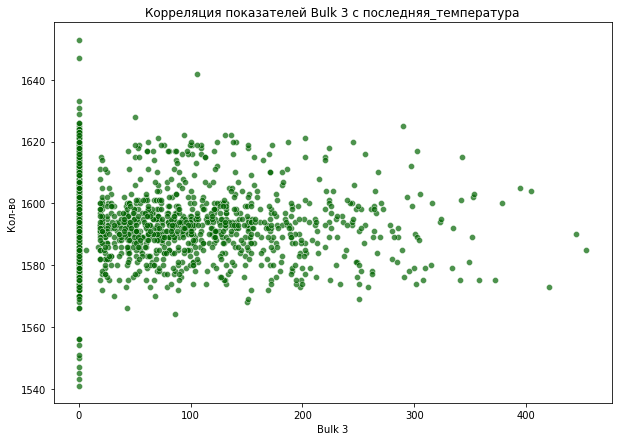

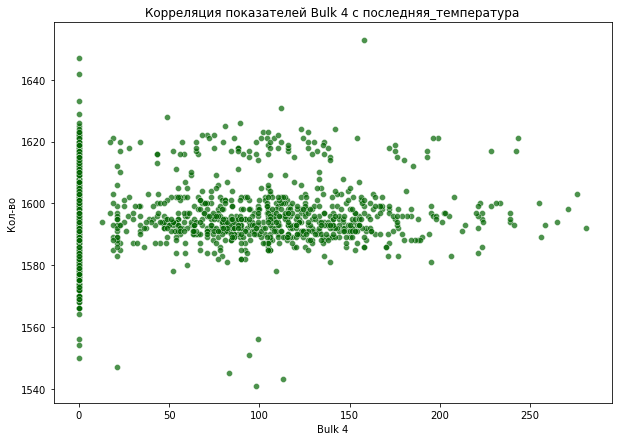

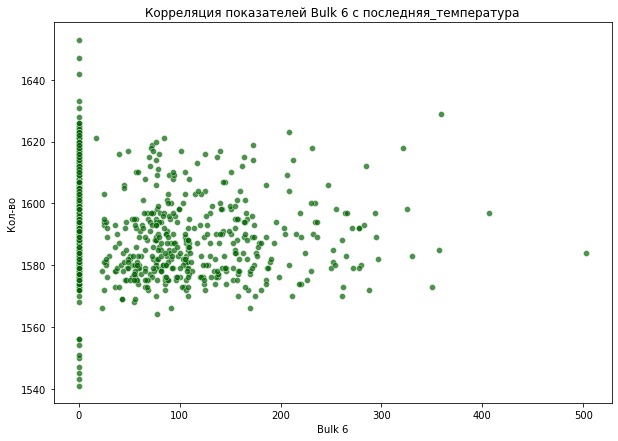

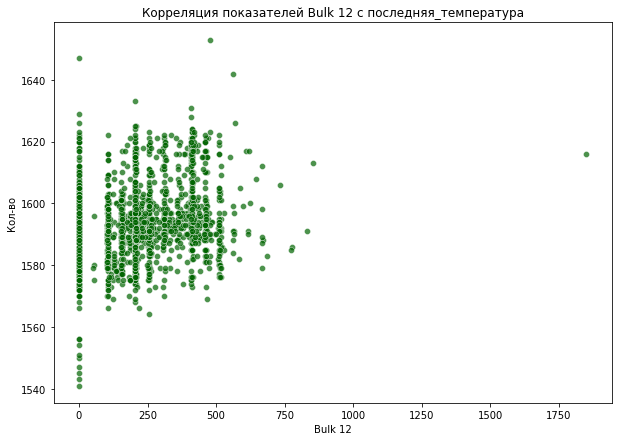

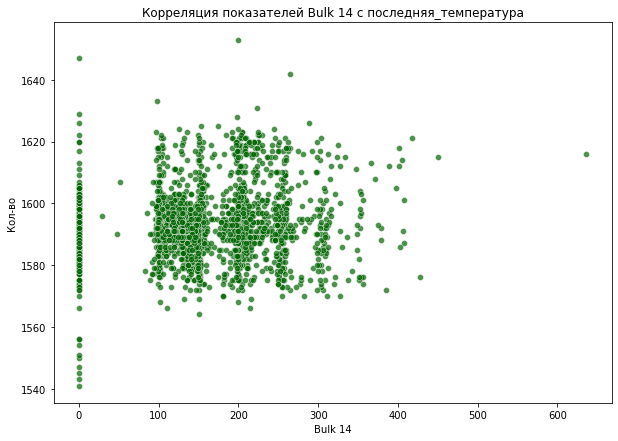

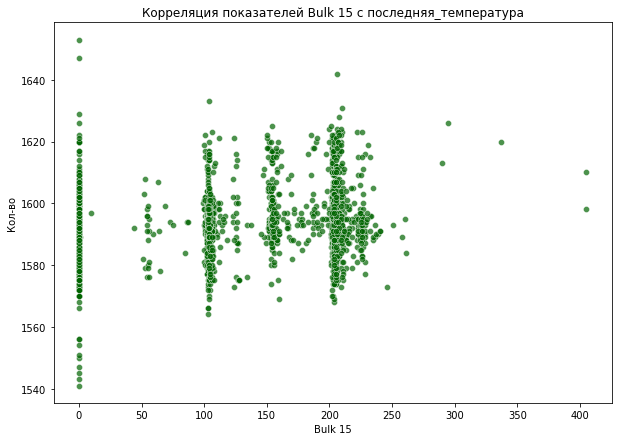

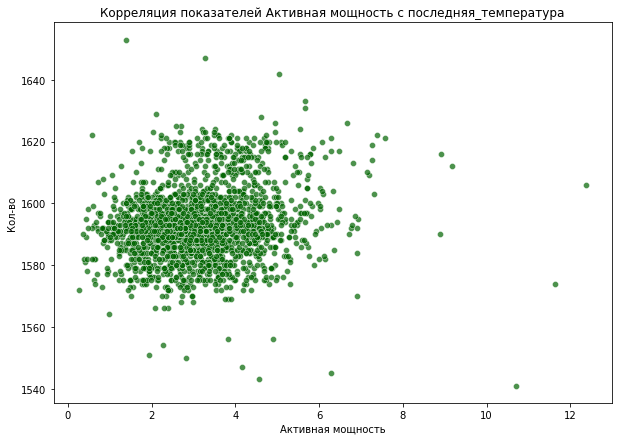

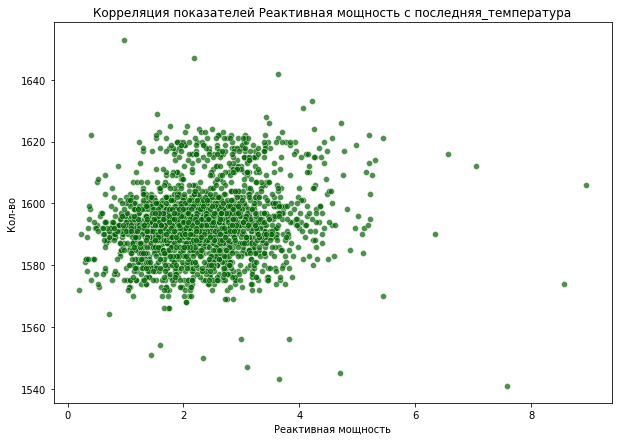

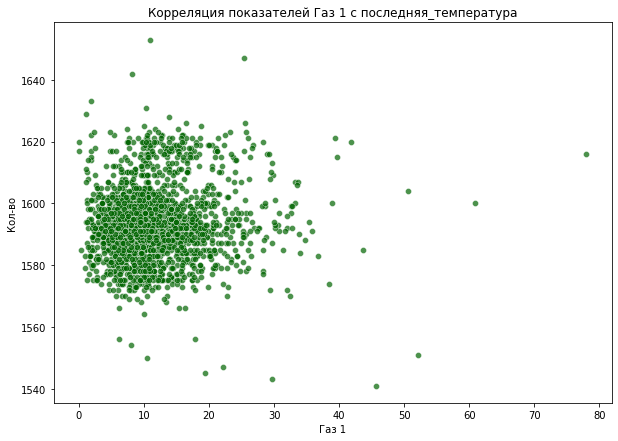

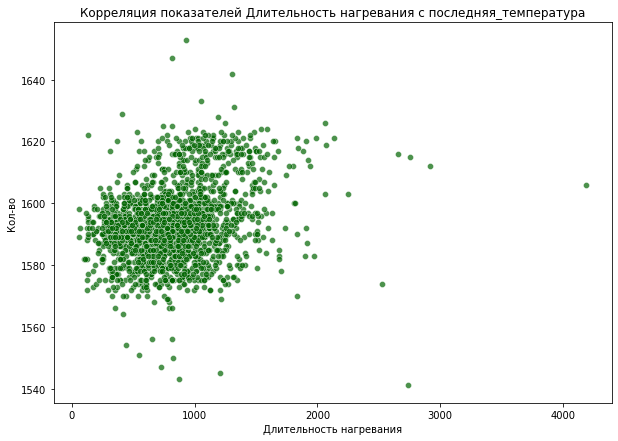

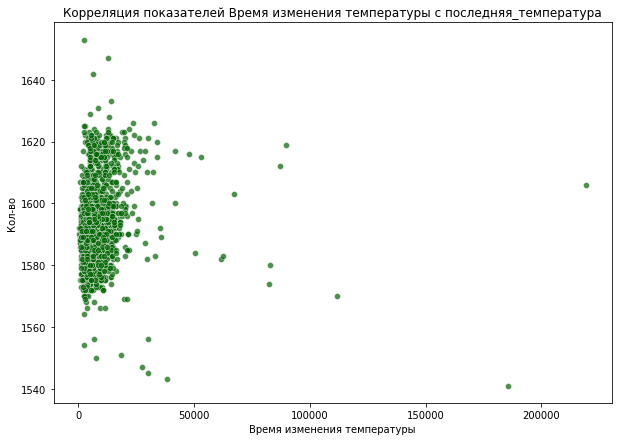

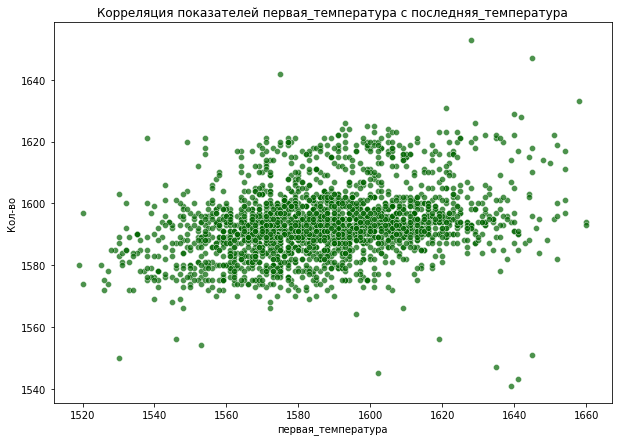

In [ ]:
correlation_plot(data_final, num_cols, 'последняя_температура')

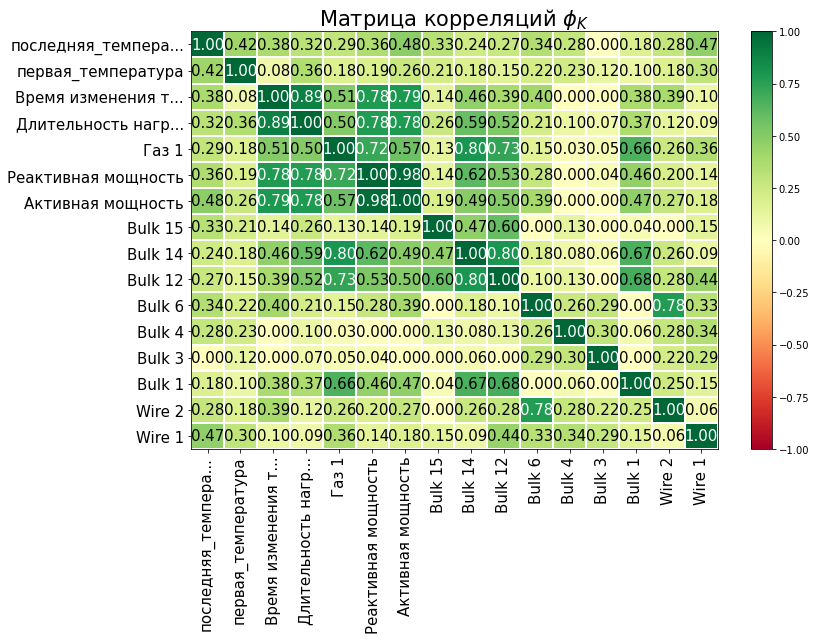

In [ ]:
num_cols = data_final.drop(['key'], axis=1).columns
df_matrix = data_final.drop(['key'], axis=1)
phik_features_matrix(df_matrix, num_cols)

Выводы по итогу корреляционного анализа:

1) Графики рассеяния:

  - Корреляция показателей обьема подачи сыпучих, проволочных материлов и инертного газа по отношению к температуре нелинейная.

  - Группы значений распределены по вертикали вдоль увеличения независимого показателя с небольшим разбросом внутри них.

  - Нелинейная зависимость наблюдается у показателей активной и реактивной мощности по отношении к температуре.

2) Матрица корреляций Фика:

  - Между последней и первой температурой средняя кореляция, всего 0.42, что хорошо, несмотря на их тесную связь в датасете с изменением температры по ковшам.

  - Также встречается средняя корреляция с сыпучими материалами Bulk 1 в 0.18 и с проволочными материалами Wire 1 в 0.47. В целом сила корреляции между признаком с последней температурой и с сыпучими, а также проволочными материалами обычно не превышает 0.48.

  - Сила корреляции с активной мощностью с последней температурой средняя, в 0.48

  - Во всех остальных случаях сила зависимости между целевыми и входными признаками слабая.

  - Прослеживается явная мультиколлинеарность между сыпучими материалами Bulk 1 и Bulk 14, а также с инертны газом. Это очень странно, поскольку Bulk 1 является не информативным признаком, т.к содержит менее 10% данных от общего объема, а судя по графикам, обьемы подачи у него низкие по сравнению с остальными. После проверки качества обучения модели, скоррее стоит очистить датасет от этого признака.

  - Наблюдается мультикооллинеарность между признками активной и реактивной мощности, сила корреляции между ними равна 1.0. Один из признаков стоит удалить.

In [ ]:
data_final = data_final.drop(['Реактивная мощность', 'Bulk 3'], axis=1)

In [ ]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2292 entries, 0 to 2328
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2292 non-null   int64  
 1   Wire 1                       2292 non-null   float64
 2   Wire 2                       2292 non-null   float64
 3   Bulk 1                       2292 non-null   float64
 4   Bulk 4                       2292 non-null   float64
 5   Bulk 6                       2292 non-null   float64
 6   Bulk 12                      2292 non-null   float64
 7   Bulk 14                      2292 non-null   float64
 8   Bulk 15                      2292 non-null   float64
 9   Активная мощность            2292 non-null   float64
 10  Газ 1                        2292 non-null   float64
 11  Длительность нагревания      2292 non-null   float64
 12  Время изменения температуры  2292 non-null   float64
 13  первая_температура

# Обучение модели

In [ ]:
num_cols

Index(['Wire 1', 'Wire 2', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12',
       'Bulk 14', 'Bulk 15', 'Активная мощность', 'Реактивная мощность',
       'Газ 1', 'Длительность нагревания', 'Время изменения температуры',
       'первая_температура', 'последняя_температура'],
      dtype='object')

In [ ]:
RANDOM_STATE = 120824
preprocessor_data = ColumnTransformer(
    [
        ('num', StandardScaler(), MinMaxScaler(), RobustScaler(), num_cols)
    ]
)

In [ ]:
"""
pipe_final = Pipeline([

    ('models', LinearRegression())
])
"""

"\npipe_final = Pipeline([\n\n    ('models', LinearRegression())\n])\n"

In [ ]:
pipe_final = Pipeline(
    [
        ('models', VotingClassifier(estimators=[
            ('cbr', CatBoostRegressor(random_state=RANDOM_STATE)),
            ('dtr', DecisionTreeRegressor(random_state=RANDOM_STATE)),
            ('lr', LinearRegression),
            ('rfr', RandomForestRegressor(random_state=RANDOM_STATE))],
              voting='soft'))
    ]
)

In [ ]:
params_rs = [

    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=10)],
        'models__learning_rate':  [0.1, 0.25],
        'models__max_depth': [10, 12],
        'models__n_estimators': [200]
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(2, 20)
    },

    {
        'models': [LinearRegression()]
    },

        {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(2, 20),
        'models__min_samples_split': range(2, 20),
        'models__n_estimators': range(10, 100)
    }

]

In [ ]:
X = data_final.drop(columns=['последняя_температура', 'key'])
y = data_final['последняя_температура']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.25)

In [ ]:
rscv = RandomizedSearchCV(
    pipe_final,
    params_rs,
    cv=5,
    n_jobs=-1, random_state=RANDOM_STATE,
    scoring='neg_mean_absolute_error')

In [ ]:
rscv.fit(X_train, y_train)
rscv.best_estimator_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Pipeline(steps=[('models',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=5,
                                       min_samples_split=6, n_estimators=42,
                                       random_state=120824))])

In [ ]:
rscv.best_score_ * (-1)

6.152840895521382

Лучшие результаты показала модель случайного леса решений(RandomForestRegressor) c такими гиперпараметрами:

 RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=6,
                      n_estimators=42, random_state=120824)

Целевая метрика MAE составила 6.15

# Предсказание модели

In [ ]:
predictions_for_test = rscv.best_estimator_.predict(X_test)
mean_absolute_error(y_test, predictions_for_test)

6.218015967123467

Качество предсказаний на тестовой выборке немного снизилось, MAE составило 6.21, что удовлетворяет условию заказчика MAE < 6.8.

# Диаграмма значимости признаков Шепли

In [ ]:
rscv.best_estimator_.named_steps

{'models': RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=6,
                       n_estimators=42, random_state=120824)}

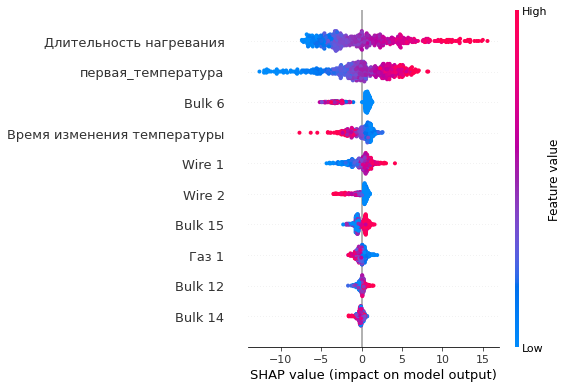

In [ ]:
explainer = shap.TreeExplainer(rscv.best_estimator_.named_steps['models'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=10)

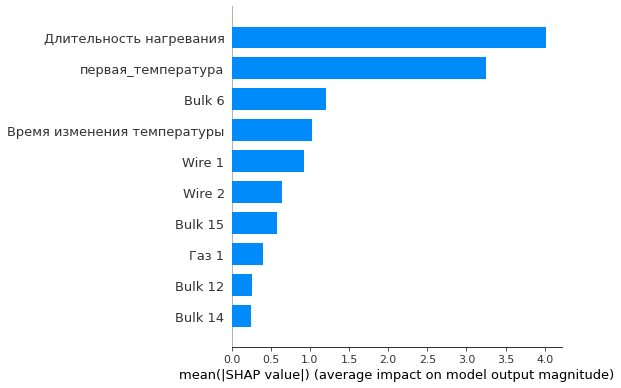

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

Анализ приоритетности признаков при предсказании модели по диаграммам Шепли:

1) Самые приоритетные признаки для модели по убыванию:

  - Длительность нагревания
  - Первая температура
  - Bulk 6(сыпучие материалы)
  - Время изменения температуры
  - Wire 1
  - Wire 2
  - Bulk 15
  - Газ 1
  - Bulk 12
  - Bulk 14

2) Новые признаки такие как Длительность нагревания и Время изменения температуры заняли важное место в списке значимых признаков для модели. Так прослеживается завивисимость от длительности нагревания, чем дольше происходит нагревание, тем выше температура. А чем дольше происходит нагревание, тем выше расход активной и реактивной мощности, следовательно потребление электроенергии продолжает расти.

3) Время изменения температуры оказывает куда меньшее влияние чем длительность нагревания, но тоже является важным признаком для модели. Чем дольше менялась температура, тем меньшее значение было у последней температуры в ковше.

4) Самым значимым признаком среди сыпучих материалов в модели является Bulk 6, чем меньший обьем был передан при легировании, тем выше температура и наоборот, но в случае с другими сыпчими материалами это не так. Поскольку мы не знаем с какими металами и хим соединениями работаем, то предположим, что Bulk 6 ,более тугоплавкий или объем больше.

5) В случае с проволычными материалами Wire 1 и Wire 2, также прослеживается их значимость для модели. Чем больший обьем Wire 1 был передан в ковш, тем выше была температура и наоборот с Wire 2.

# Общий вывод и рекомендации заказчику

 Все необходимые шаги по работе над заказанным исследованием металлургического коимбината были выполнены.

 Произведено знакомство с датасетами о подаче электродов к ковшу, об объеме и времени подачи сыпучих материалов, о объеме подачи инертного газа, об объеме и времени поступления проволочных материалов в сплав. А также данные об изменении температуры во времени по ковшу. После первоначальной предобработки был проведен исследовательский анализ, по итогам которого я сделал следующие выводы об имеющихся данных:

1) Данные о нагреве спомощью эелектродов(датасет data_arc_new):

  - Активная мощность распределена нормально, среднее 0.66, область нормальных значений от 0.4 до 0.8.

  - Реактиваня мощность распредлена нормально, среднее 0.48, область нормальных значений 0.4 до 0.6.

  - Структура данных такая: каждая отдельная процедура переплавки сопровождается множеством подач электродов к ковшу, в процессе подачи температура металла меняется.

2) Данные о сыпучих материалах(data_bulk_new):

  - В датасете присутвует 15 различных признаков, характеризующих обьем подачи сыпучих материалов.

  - Большинство признаков не информативны, там попросту не хватает данных, многие заполнены менее чем на 10%, скорее всего такие признаки лучше не брать во внимании при дальнейшем обучении модели, стоит оставить только те признаки, в которых достаточно данных. Мы не знаем насколько были спецефичны те или иные сыпучие матриалы, поскольку качество у поступающей на предприятие руды разное и везут ее из разных регионов.

3) Данные о подаче инертных газов(азот)(data_gas_new):

  - Данные распределены нормально, среднее 11, область нормальных значений от 0 до 25, область между первым и третьим квартилем от 7, до 13.7.

  - Максимальное значение 80, что в 8 раз выше нормы и одноится к райнему выбросу, однако это не аномалия и пока не вижу смысла предпринимать меры по предобработке данных в этом датасете.

4) Данные об изменении температуры(data_temp_new):

  - Распределние температуры норамльное, среднее 1590, большинство значений находятся в диапазоне от 1560 и до 1630.

  - Максимальный показатель равен 1711, минимальный 1191. Минимум значительно отличается от средних показателей, в районе 1200 находится целая группа таких значений, трудно предсказать природу их появления, к тому же такие занчения наблюдаются на разных партиях металла, значит это значение было начальным для этих партий, после чего пришло в норму.

5) Данные о проволочных материалах(data_wire_new):

  - В датасете пристутсвует 9 различных признаков, каждый из которых связан с конкретным металлом, из которого и изготовлене проволока.

  - Пристутствуют аналогичные проблемы, что и в датасете с сыпучими материалами, слишком низкая информативность данных, поэтому часть признаков не будет передана модели.

6) Датасеты и с датой и временем:

  - Эти данные не несут полезной нагрузки для обучения модели и учавствовать в нём не будут.

7) Столбцы с датой и временем:

  - Столбцы со временм в датасетах с подачей электродов и температурой могут быть полезны для предсказаний, их можно агрегировать и узнать сколько занимают целевые действия по ковшу.

Впоследствии была проведены процедуры агрегации по датасетам с подачсей электродов и изменением температуры в ковше, а также были сформированы новые признаки с временными промежутками нагревания ковша и изменния температуры. Также был выделен целевой признак последняя температура, т.е последнее зафиксированное изменение оной и первая температура как входной признак. Все участвующие датасеты и признаки были объединены в один датасет. Были убраны дубликаты и датасет был подготовлен для последующего обучения.

После подготовки данных был проведен исследовательский и корреляционный анализ нового, объединенного датасета. Были отмечены некоторые выбивающиеся из общей картины моменты связанные с общим временем изменнеия температуры в ковше, так в редких случаях процедура длилась более суток, при том, что  в среднем на партию уходит 2 часа. На эти партии было затрачено многократно большее кол-во ресурсов и времени чем на обычные. Такие редкие случаи являются очень затратными для предприятия. Неэффективное использование временных ресурсов, а также высокие расходы на электроенергию, могут серьезно снизить чистую прибыль предприятия, насмотря на исключительный характер описываемыхъ мной случаев.

По итогам корреляционного анализа были сделаны выводы:

1) Графики рассеяния:

  - Корреляция показателей обьема подачи сыпучих, проволочных материлов и инертного газа по отношению к температуре нелинейная.

  - Группы значений распределены по вертикали вдоль увеличения независимого показателя с небольшим разбросом внутри них.

  - Нелинейная зависимость наблюдается у показателей активной и реактивной мощности по отношении к температуре.

2) Матрица корреляций Фика:

  - Между последней и первой температурой средняя кореляция, всего 0.42, что хорошо, несмотря на их тесную связь в датасете с изменением температры по ковшам.

  - Также встречается средняя корреляция с сыпучими материалами Bulk 1 в 0.18 и с проволочными материалами Wire 1 в 0.47. В целом сила корреляции между признаком с последней температурой и с сыпучими, а также проволочными материалами обычно не превышает 0.48.

  - Сила корреляции с активной мощностью с последней температурой средняя, в 0.48

  - Во всех остальных случаях сила зависимости между целевыми и входными признаками слабая.

  - Прослеживается явная мультиколлинеарность между сыпучими материалами Bulk 1 и Bulk 14, а также с инертны газом. Это очень странно, поскольку Bulk 1 является не информативным признаком, т.к содержит менее 10% данных от общего объема, а судя по графикам, обьемы подачи у него низкие по сравнению с остальными. После проверки качества обучения модели, скоррее стоит очистить датасет от этого признака.

  - Наблюдается мультикооллинеарность между признками активной и реактивной мощности, сила корреляции между ними равна 1.0. Один из признаков стоит удалить.

 Затем данные были разделены на обучающую и тестовую выборку, а также был собран пайплайн с ансамблем моделей, который состоял из бустинговой модели, дерева решений, леса решений и линейной регрессии.

 По итогу обучения модели лучшие результаты показала модель лес решений(RandomForestRegressor). При предсказании на тестовой выборки качество целевой метрики MAE составило 6.21, что удовлетворяет критерию заказчика MAE < 6.8. Обучение и прогнозирование модели было проведено успешно.

 Также был проведен анализ важности признаков для модели по итогам которог были сделаны следущие выводы:

 1) Самые приоритетные признаки для модели по убыванию:

  - Длительность нагревания
  - Первая температура
  - Bulk 6(сыпучие материалы)
  - Время изменения температуры
  - Wire 1
  - Wire 2
  - Bulk 15
  - Газ 1
  - Bulk 12
  - Bulk 14

2) Новые признаки такие как Длительность нагревания и Время изменения температуры заняли важное место в списке значимых признаков для модели. Так прослеживается завивисимость от длительности нагревания, чем дольше происходит нагревание, тем выше температура. А чем дольше происходит нагревание, тем выше расход активной и реактивной мощности, следовательно потребление электроенергии продолжает расти.

3) Время изменения температуры оказывает куда меньшее влияние чем длительность нагревания, но тоже является важным признаком для модели. Чем дольше менялась температура, тем меньшее значение было у последней температуры в ковше.

4) Самым значимым признаком среди сыпучих материалов в модели является Bulk 6, чем меньший обьем был передан при легировании, тем выше температура и наоборот, но в случае с другими сыпчими материалами это не так. Поскольку мы не знаем с какими металами и хим соединениями работаем, то предположим, что Bulk 6 ,более тугоплавкий или объем больше.

5) В случае с проволычными материалами Wire 1 и Wire 2, также прослеживается их значимость для модели. Чем больший обьем Wire 1 был передан в ковш, тем выше была температура и наоборот с Wire 2.

По итогу проведенного объема работы над проектом по предсказанию оптимальных температур металла в ковше для металлургического комбината мной были достигнуты все необходимые цели исследования, по результатам которого я готов предоставить следующие рекомендации.

Рекомендуется составить список с разными категориями железной руды поступающих из различных регионов добычи, добавить по каждой категории характеристики и установить рекомендованные промежутки объемов материалов необходимых для легирования. А также установить оптимальную темперутру для каждой такой категории металла, которую будет не трудно найти благодаря обученной ранее модели. Предпринятые меры помогут ускорить цикл легирования металла в ковше, повысить общие ожидания от постпающего металла и снизить общие затраты на изготовление продукции, а именно металлических плит. Для предприятия критически важно контролировать объем затраченной электроенергии. Перерасход электроенергии не только повышает затраты и снижает рентабельность производства, но и повышает износ обородувания, что может привести даже к угрозе жизни для ряда сотрудников предприятия, а также к простою и неэффективномому функционированию комбината. Не будем забывать, что речь идет о поставленном на поток выпуске металлургической продукции, где каждый ковш содержит 100 тонн расплавленного металла, что примерно соответсвует 7 кубометрам, весь процесс является комплексным и требует контроля, в особенности над температурой в ковше.

Также рекомендую проводить предварительный химический анализ мизерного кол-ва поступившей руды из партии, это поможет повысить ожидания от последующей металлобработки. Появитьс явозможность подготовить примерное необходимое кол-во сыпучих и проволочных материалов заранее, например для того чтобы свериться, хватит ли их в запасах для следующего ковша или нет.